In [99]:
%matplotlib nbagg
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from alvra_tools.load_data import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm

In [138]:
scan_name = "RuDimerACN_monoscan_0p6ps_020"


DIR = "/sf/alvra/data/p17983/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17983/res/scan_info/"

#DIR = "/das/work/p17/p17983/Example_data/raw/scan_data/" + scan_name + "/"
#DIR_json = "/das/work/p17/p17983/Example_data/res/scan_info/"


!ls -lah -rt $DIR
!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)


total 1.2T
drwxrwsr-x. 192 17983 p17983  32K Jul 29 09:17 ..
-rw-r--r--.   1 17983 p17983  12G Jul 29 09:18 RuDimerACN_monoscan_0p6ps_020_step0000.JF02T09V02.h5
-rw-r--r--.   1 17983 p17983  16G Jul 29 09:18 RuDimerACN_monoscan_0p6ps_020_step0000.JF06T32V01.h5
-rw-r--r--.   1 root  p17983 115K Jul 29 09:18 RuDimerACN_monoscan_0p6ps_020_step0000.BSREAD_CA.h5
-rw-r--r--.   1 17983 p17983  12G Jul 29 09:19 RuDimerACN_monoscan_0p6ps_020_step0001.JF02T09V02.h5
-rw-r--r--.   1 17983 p17983  16G Jul 29 09:19 RuDimerACN_monoscan_0p6ps_020_step0001.JF06T32V01.h5
-rw-r--r--.   1 root  p17983 323M Jul 29 09:19 RuDimerACN_monoscan_0p6ps_020_step0000.BSREAD.h5
-rw-r--r--.   1 root  p17983 108K Jul 29 09:19 RuDimerACN_monoscan_0p6ps_020_step0001.BSREAD_CA.h5
-rw-r--r--.   1 17983 p17983  12G Jul 29 09:20 RuDimerACN_monoscan_0p6ps_020_step0002.JF02T09V02.h5
-rw-r--r--.   1 17983 p17983  16G Jul 29 09:20 RuDimerACN_monoscan_0p6ps_020_step0002.JF06T32V01.h5
-rw-r--r--.   1 root  p17983 323M Jul 29 09:2

ra-c-003.psi.ch
There are 175 files in the folder /sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_0p6ps_020/


# Load one step and filter some data from I0

In [120]:
f ="RuDimerACN_monoscan_0p6ps_018_step0003.BSREAD.h5"
fn = DIR + f

(DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Energy_shot, \
 DataTrans_pump_shot, DataTrans_unpump_shot) = load_PumpProbe_events(fn, channel_energy)

IzeroFEL_pump_original = IzeroFEL_pump_shot.copy()
IzeroFEL_unpump_original = IzeroFEL_unpump_shot.copy()
print (np.median(IzeroFEL_pump_shot))# - 2*(np.std(IzeroFEL_pump_shot)))

conditionPumpMax = IzeroFEL_pump_shot < np.median(IzeroFEL_pump_shot)+3*(np.std(IzeroFEL_pump_shot))
conditionPumpMin = IzeroFEL_pump_shot > np.median(IzeroFEL_pump_shot)-3*(np.std(IzeroFEL_pump_shot))

conditionUnPumpMax = IzeroFEL_unpump_shot < np.median(IzeroFEL_unpump_shot)+3*(np.std(IzeroFEL_unpump_shot))
conditionUnPumpMin = IzeroFEL_unpump_shot > np.median(IzeroFEL_unpump_shot)-3*(np.std(IzeroFEL_unpump_shot))

conditionGeneral = IzeroFEL_pump_shot > 0.001
conditionGeneral2 = IzeroFEL_unpump_shot > 0.001

IzeroFEL_pump_shot = IzeroFEL_pump_shot[conditionPumpMin & conditionPumpMax & conditionUnPumpMin & conditionUnPumpMax & conditionGeneral & conditionGeneral2]
IzeroFEL_unpump_shot = IzeroFEL_unpump_shot[conditionPumpMin & conditionPumpMax & conditionUnPumpMin & conditionUnPumpMax & conditionGeneral & conditionGeneral2]

#Izero_pump_loop = [x for x in Izero_unpump_loop if (np.abs(x) > 1000)]

IzeroFEL_pump_shot = np.asarray(IzeroFEL_pump_shot)
IzeroFEL_pump_original = np.asarray(IzeroFEL_pump_original)

print (IzeroFEL_pump_original.shape, IzeroFEL_unpump_original.shape)
print (IzeroFEL_pump_shot.shape, IzeroFEL_unpump_shot.shape)



0.05990385636687279
(1250, 1) (1250, 1)
(1216,) (1216,)


<IPython.core.display.Javascript object>


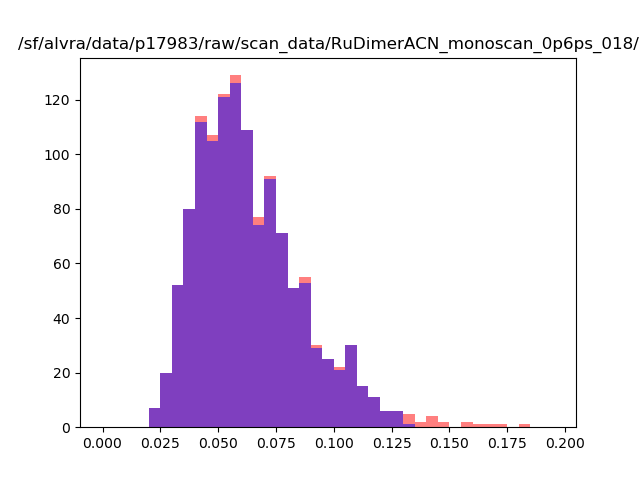

1250 1216


In [121]:
#num_bins = 100
plt.figure()
plt.hist(IzeroFEL_pump_original, bins =np.arange(0,0.2,0.005), facecolor='red', alpha=0.5)
plt.hist(IzeroFEL_pump_shot, bins =np.arange(0,0.2,0.005), facecolor='blue', alpha=0.5)
#plt.hist(Izero_unpump_original, bins =np.arange(0,15000,100), facecolor='blue', alpha=0.5)

plt.title(DIR)
plt.show()
print (IzeroFEL_pump_original.size, IzeroFEL_pump_shot.size)

# Load mono scan

In [145]:
json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 35

print ("Processing",numFiles,"files")

DataFluo_pump = []
DataFluo_unpump = []
err_DataFluo_pump = []
err_DataFluo_unpump = []

DataTrans_pump = []
DataTrans_unpump = []
err_DataTrans_pump = []
err_DataTrans_unpump = []

Pump_probe = []
err_Pump_probe = []

Energy_eV = []


# from itertools import chain
# concatenated = chain(range(0,37), range(43, 50))
# for i in concatenated:
for i in range(0,numFiles):             
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists and i!=0:
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        (DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Energy_shot, \
         DataTrans_pump_shot, DataTrans_unpump_shot) = load_PumpProbe_events(filename, channel_energy)
              
        threshold_pump = IzeroFEL_pump_shot > 0.02
        threshold_unpump = IzeroFEL_unpump_shot > 0.02
        condition_pump = IzeroFEL_pump_shot > np.median(IzeroFEL_pump_shot)-3*(np.std(IzeroFEL_pump_shot))
        condition_unpump = IzeroFEL_unpump_shot > np.median(IzeroFEL_unpump_shot)-3*(np.std(IzeroFEL_unpump_shot))

        DataFluo_pump_shot = DataFluo_pump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        IzeroFEL_pump_shot = IzeroFEL_pump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        DataTrans_pump_shot = DataTrans_pump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
              
        DataFluo_unpump_shot = DataFluo_unpump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        IzeroFEL_unpump_shot = IzeroFEL_unpump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        DataTrans_unpump_shot = DataTrans_unpump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
    
              
        DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
        DataTrans_pump_shot_norm = DataTrans_pump_shot / IzeroFEL_pump_shot
        DataTrans_unpump_shot_norm = DataTrans_unpump_shot / IzeroFEL_unpump_shot

        
              
        Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
        
        DataFluo_pump.append(DataFluo_pump_shot_norm.mean())
        DataFluo_unpump.append(DataFluo_unpump_shot_norm.mean())
        DataTrans_pump.append(DataTrans_pump_shot_norm.mean())
        DataTrans_unpump.append(DataTrans_unpump_shot_norm.mean())
        
        Pump_probe.append(Pump_probe_shot.mean())
        
        err_DataFluo_pump.append(DataFluo_pump_shot_norm.std()/np.sqrt(DataFluo_pump_shot_norm.size))
        err_DataFluo_unpump.append(DataFluo_unpump_shot_norm.std()/np.sqrt(DataFluo_unpump_shot_norm.size))
        err_DataTrans_pump.append(DataTrans_pump_shot_norm.std()/np.sqrt(DataTrans_pump_shot_norm.size))
        err_DataTrans_unpump.append(DataTrans_unpump_shot_norm.std()/np.sqrt(DataTrans_unpump_shot_norm.size))
              
        err_Pump_probe.append(Pump_probe_shot.std()/np.sqrt(Pump_probe_shot.size))
        
   #     Energy_eV.append()
        Energy_shot = [x for x in Energy_shot if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(Energy_shot))
    
DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
DataTrans_pump = np.asarray(DataTrans_pump)
DataTrans_unpump = np.asarray(DataTrans_unpump)
              
Pump_probe = np.asarray(Pump_probe)
err_Pump_probe = np.asarray(err_Pump_probe)
              
err_DataFluo_pump = np.asarray(err_DataFluo_pump)
err_DataFluo_unpump = np.asarray(err_DataFluo_unpump)
err_DataTrans_pump = np.asarray(err_DataTrans_pump)
err_DataTrans_unpump = np.asarray(err_DataTrans_unpump)
            
Energy_eV = np.asarray(Energy_eV)

print ("Job done!")


/sf/alvra/data/p17983/res/scan_info/RuDimerACN_monoscan_0p6ps_020_scan_info.json
Processing 52 files
step 2 of 52 : Processing /sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_0p6ps_020/RuDimerACN_monoscan_0p6ps_020_step0001.BSREAD.h5
step 3 of 52 : Processing /sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_0p6ps_020/RuDimerACN_monoscan_0p6ps_020_step0002.BSREAD.h5
step 4 of 52 : Processing /sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_0p6ps_020/RuDimerACN_monoscan_0p6ps_020_step0003.BSREAD.h5
step 5 of 52 : Processing /sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_0p6ps_020/RuDimerACN_monoscan_0p6ps_020_step0004.BSREAD.h5
step 6 of 52 : Processing /sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_0p6ps_020/RuDimerACN_monoscan_0p6ps_020_step0005.BSREAD.h5
step 7 of 52 : Processing /sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_0p6ps_020/RuDimerACN_monoscan_0p6ps_020_step0006.BSREAD.h5
step 8 of 52 : Processing /sf/alvra/data/p17983/raw/s

# Plot energy scans

<IPython.core.display.Javascript object>


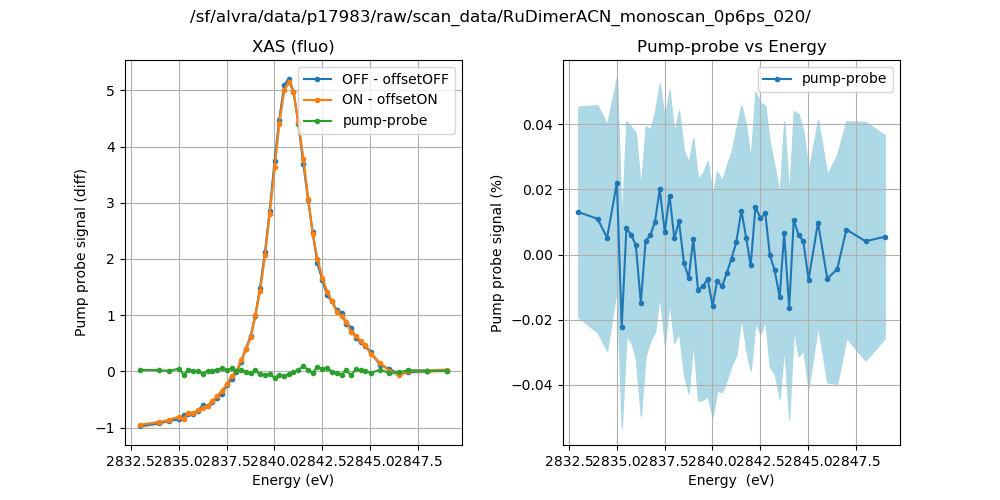

In [146]:
plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)
scale=1
#plt.title(DIR,horizontalalignment='right')

Pump_probe = (DataFluo_pump - DataFluo_unpump) / DataFluo_unpump

offset_corr_DataFluo_pump = scale*DataFluo_pump - np.mean(scale*DataFluo_pump[:5])
offset_corr_DataFluo_unpump = scale*DataFluo_unpump - np.mean(scale*DataFluo_unpump[:5])
offset_corr_pump_probe = offset_corr_DataFluo_pump - offset_corr_DataFluo_unpump

low_err_pump_offset       = offset_corr_DataFluo_pump - err_DataFluo_pump
high_err_pump_offset      = offset_corr_DataFluo_pump + err_DataFluo_pump
low_err_unpump_offset     = offset_corr_DataFluo_unpump - err_DataFluo_unpump
high_err_unpump_offset    = offset_corr_DataFluo_unpump + err_DataFluo_unpump
low_err_pumpprobe_offset  = (Pump_probe) - np.sqrt(err_DataFluo_pump**2+err_DataFluo_unpump**2)
high_err_pumpprobe_offset = (Pump_probe) + np.sqrt(err_DataFluo_pump**2+err_DataFluo_unpump**2)

low_err_pump = DataFluo_pump - err_DataFluo_pump
high_err_pump = DataFluo_pump + err_DataFluo_pump
low_err_unpump = DataFluo_unpump - err_DataFluo_unpump
high_err_unpump = DataFluo_unpump + err_DataFluo_unpump
low_err_pumpprobe = (Pump_probe) - np.sqrt(err_DataFluo_pump**2+err_DataFluo_unpump**2)
high_err_pumpprobe = (Pump_probe) + np.sqrt(err_DataFluo_pump**2+err_DataFluo_unpump**2)

plt.subplot(1,2,1)
plt.plot(Energy_eV, offset_corr_DataFluo_unpump, label="OFF - offsetOFF",marker='.')
plt.plot(Energy_eV, offset_corr_DataFluo_pump, label="ON - offsetON",marker='.')
plt.plot(Energy_eV, offset_corr_pump_probe, label='pump-probe', marker='.')
plt.fill_between(Energy_eV, scale*low_err_pump_offset, scale*high_err_pump_offset, color='lightblue')
plt.fill_between(Energy_eV, scale*low_err_unpump_offset, scale*high_err_unpump_offset, color='navajowhite')
#plt.fill_between(Energy_eV, scale*low_err_pumpprobe_offset, scale*high_err_pumpprobe_offset, color='lightblue')
plt.xlabel("Energy (eV)")
plt.ylabel ("Pump probe signal (diff)")
plt.gca().set_title('XAS (fluo)')
plt.legend(loc="best")
plt.grid()

# plt.subplot(1,2,1)
# plt.plot(Energy_eV, scale*DataFluo_pump, label="ON",marker='.')
# plt.plot(Energy_eV, scale*DataFluo_unpump, label="OFF",marker='.')
# plt.fill_between(Energy_eV, scale*low_err_pump, scale*high_err_pump, color='lightblue')
# plt.fill_between(Energy_eV, scale*low_err_unpump, scale*high_err_unpump, color='navajowhite')
# plt.xlabel("Energy (eV)")
# plt.gca().set_title('XAS (fluo)')
# plt.legend(loc="best")

plt.subplot(1,2,2)
plt.plot(Energy_eV, scale*(Pump_probe), label="pump-probe",marker='.')
plt.fill_between(Energy_eV, scale*low_err_pumpprobe, scale*high_err_pumpprobe, color='lightblue')
plt.grid()
plt.ylabel ("Pump probe signal (%)")
plt.xlabel("Energy  (eV)")
plt.gca().set_title('Pump-probe vs Energy')
plt.legend(loc="best")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.3,hspace = 0.5) 

plt.show()

# Summing scans

In [ ]:
#Pump_probe_37=Pump_probe.copy()
#err_Pump_probe_37=err_Pump_probe.copy()
#Pump_probe_38=Pump_probe.copy()
#err_Pump_probe_38=err_Pump_probe.copy()
#Pump_probe_39=Pump_probe.copy()
#err_Pump_probe_39=err_Pump_probe.copy()
#Pump_probe_40=Pump_probe.copy()
#err_Pump_probe_40=err_Pump_probe.copy()

#Pump_probe_22=Pump_probe.copy()
#err_Pump_probe_22=err_Pump_probe.copy()
#Pump_probe_24=Pump_probe.copy()
#err_Pump_probe_24=err_Pump_probe.copy()
#Pump_probe_25=Pump_probe.copy()
#err_Pump_probe_25=err_Pump_probe.copy()

#Pump_probe_41=Pump_probe.copy()
#err_Pump_probe_41=err_Pump_probe.copy()
#Pump_probe_42=Pump_probe.copy()
#err_Pump_probe_42=err_Pump_probe.copy()
#Pump_probe_43=Pump_probe.copy()
#err_Pump_probe_43=err_Pump_probe.copy()
#Pump_probe_44=Pump_probe.copy()
#err_Pump_probe_44=err_Pump_probe.copy()


#Pump_probe_34=Pump_probe.copy()
#err_Pump_probe_34=err_Pump_probe.copy()
#Pump_probe_35=Pump_probe.copy()
#err_Pump_probe_35=err_Pump_probe.copy()
#Pump_probe_36=Pump_probe.copy()
#err_Pump_probe_36=err_Pump_probe.copy()

#Pump_probe_28=Pump_probe.copy()
#err_Pump_probe_28=err_Pump_probe.copy()
#Pump_probe_32=Pump_probe.copy()
#err_Pump_probe_32=err_Pump_probe.copy()
#Pump_probe_36=Pump_probe.copy()
#err_Pump_probe_36=err_Pump_probe.copy()
#
#Pump_probe_02=Pump_probe.copy()
#err_Pump_probe_02=err_Pump_probe.copy()
#Pump_probe_01=Pump_probe.copy()
#err_Pump_probe_01=err_Pump_probe.copy()
Pump_probe_03=Pump_probe.copy()
err_Pump_probe_03=err_Pump_probe.copy()


In [ ]:
plt.figure(figsize = (10,5))
plt.plot(Energy_eV, scale*(Pump_probe_01), label="200 mJ 5 ps",marker='.')
plt.plot(Energy_eV, scale*(Pump_probe_02), label="130 mJ 0.1 ps",marker='.')
plt.xlabel("Energy  (eV)")
plt.grid()
plt.gca().set_title('Pump-probe vs Energy')
plt.legend(loc="best")
plt.legend(loc="best")
plt.show()

In [ ]:
Pump_probe_sum=Pump_probe_37 + Pump_probe_38 + Pump_probe_39 +  Pump_probe_40
err_Pump_probe_sum=np.sqrt((err_Pump_probe_37)**2 + (err_Pump_probe_38)**2 + (err_Pump_probe_39)**2 + (err_Pump_probe_40)**2)

Pump_probe_sum_new=Pump_probe_41 + Pump_probe_42 + Pump_probe_43 + Pump_probe_44
err_Pump_probe_sum_new=np.sqrt((err_Pump_probe_41)**2 + (err_Pump_probe_42)**2 + (err_Pump_probe_43)**2 + (err_Pump_probe_44)**2)

Pump_probe_sum_old=Pump_probe_22 + Pump_probe_24 + Pump_probe_25
err_Pump_probe_sum_old=np.sqrt((err_Pump_probe_22)**2 + (err_Pump_probe_24)**2 + (err_Pump_probe_25)**2)

Pump_probe_sum_all=Pump_probe_37 + Pump_probe_38 + Pump_probe_39 +  Pump_probe_40 + Pump_probe_41 + Pump_probe_42 + Pump_probe_43 + Pump_probe_44
err_Pump_probe_sum_all=np.sqrt((err_Pump_probe_37)**2 + (err_Pump_probe_38)**2 + (err_Pump_probe_39)**2 + (err_Pump_probe_40)**2+(err_Pump_probe_41)**2 + (err_Pump_probe_42)**2 + (err_Pump_probe_43)**2 + (err_Pump_probe_44)**2)


Pump_probe_sum_all_77uJ=Pump_probe_34 + Pump_probe_35 + Pump_probe_36 
err_Pump_probe_sum_all_77uJ=np.sqrt((err_Pump_probe_34)**2 + (err_Pump_probe_35)**2 + (err_Pump_probe_36)**2 )

Pump_probe_sum_all_30uJ=Pump_probe_28 + Pump_probe_31 + Pump_probe_32
err_Pump_probe_sum_all_30uJ=np.sqrt((err_Pump_probe_28)**2 + (err_Pump_probe_31)**2 + (err_Pump_probe_32)**2 )

Pump_probe_sum_all_highF=Pump_probe_28 + Pump_probe_31 + Pump_probe_32
err_Pump_probe_sum_all_30uJ=np.sqrt((err_Pump_probe_28)**2 + (err_Pump_probe_31)**2 + (err_Pump_probe_32)**2 )

## Plotting sumed scans

In [ ]:
scale = 1/8
plt.figure(figsize = (10,5))
plt.suptitle('sum 41-44 vrs. 37-40' , fontsize=12)
plt.subplot(1,2,1)
plt.plot()
plt.plot(Energy_eV, scale*(Pump_probe_sum_all), label="pump-probe_sum_all",marker='.')
low_err_pumpprobe_sum_all = Pump_probe_sum_all - err_Pump_probe_sum_all 
high_err_pumpprobe_sum_all = Pump_probe_sum_all + err_Pump_probe_sum_all 
plt.fill_between(Energy_eV, scale*low_err_pumpprobe_sum_all, scale*high_err_pumpprobe_sum_all, color='lightblue')
scale = 1/3
plt.plot(Energy_eV, scale*(Pump_probe_sum_all_77uJ), label="pump-probe_sum_all_77uJ",marker='.')
low_err_pumpprobe_sum_all = Pump_probe_sum_all_77uJ - err_Pump_probe_sum_all_77uJ 
high_err_pumpprobe_sum_all = Pump_probe_sum_all_77uJ + err_Pump_probe_sum_all_77uJ 
plt.fill_between(Energy_eV, scale*low_err_pumpprobe_sum_all, scale*high_err_pumpprobe_sum_all, color='lightblue')
scale = 1/3
plt.plot(Energy_eV, scale*(Pump_probe_sum_all_30uJ), label="pump-probe_sum_all_30uJ",marker='.')
low_err_pumpprobe_sum_all = Pump_probe_sum_all_30uJ - err_Pump_probe_sum_all_30uJ 
high_err_pumpprobe_sum_all = Pump_probe_sum_all_30uJ + err_Pump_probe_sum_all_30uJ 
plt.fill_between(Energy_eV, scale*low_err_pumpprobe_sum_all, scale*high_err_pumpprobe_sum_all, color='lightblue')
#scale = 1/4
#plt.plot(Energy_eV, scale*(Pump_probe_sum_new), label="pump-probe_sum_41-44",marker='.')
#low_err_pumpprobe_sum_new = Pump_probe_sum_new - err_Pump_probe_sum_new 
#high_err_pumpprobe_sum_new = Pump_probe_sum_new + err_Pump_probe_sum_new 

#plt.fill_between(Energy_eV, scale*low_err_pumpprobe_sum_new, scale*high_err_pumpprobe_sum_new, color='lightblue')
plt.grid()

plt.xlabel("Energy  (eV)")
plt.gca().set_title('Pump-probe vs Energy')
plt.legend(loc="best")
plt.legend(loc="best")
plt.show()

plt.subplot(1,2,2)
plt.plot(Energy_eV, scale*(Pump_probe_41), label="41",marker='.')
plt.plot(Energy_eV, scale*(Pump_probe_42), label="42",marker='.')
plt.plot(Energy_eV, scale*(Pump_probe_43), label="43",marker='.')
plt.plot(Energy_eV, scale*(Pump_probe_44), label="44",marker='.')


#low_err_pumpprobe_25 = Pump_probe_25 - err_Pump_probe_25 
#high_err_pumpprobe_25 = Pump_probe_25 + err_Pump_probe_25 
#plt.fill_between(Energy_eV, scale*low_err_pumpprobe_25, scale*high_err_pumpprobe_25, color='lightblue')
plt.grid()

plt.legend(loc="best")



In [ ]:
Pump_probe_15uJ = Pump_probe.copy()
DataFluo_pump_15uJ = DataFluo_pump.copy()
DataFluo_unpump_15uJ = DataFluo_unpump.copy()

In [ ]:
import pandas as pd
DIR_save = "/das/work/p17/p17589/Extract_data_MbNo/"
file2save = DIR_save + scan_name + ".txt"
pd.DataFrame({
    'pump_probe': Pump_probe_15uJ,
    'signal_on' : DataFluo_pump_15uJ,
    'signal_off' : DataFluo_unpump_15uJ,
}).to_csv(file2save,index=False)

In [ ]:
plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)
scale=1
#plt.title(DIR,horizontalalignment='right')
low_err_pump = DataTrans_pump - err_DataTrans_pump
high_err_pump = DataTrans_pump + err_DataTrans_pump
low_err_unpump = DataTrans_unpump - err_DataTrans_unpump
high_err_unpump = DataTrans_unpump + err_DataTrans_unpump
low_err_pumpprobe = (Pump_probe) - np.sqrt(err_DataTrans_pump**2+err_DataTrans_unpump**2)
high_err_pumpprobe = (Pump_probe) + np.sqrt(err_DataTrans_pump**2+err_DataTrans_unpump**2)

plt.subplot(1,2,1)
plt.plot(Energy_eV, scale*DataTrans_pump, label="ON",marker='.')
plt.plot(Energy_eV, scale*DataTrans_unpump, label="OFF",marker='.')
plt.fill_between(Energy_eV, scale*low_err_pump, scale*high_err_pump, color='lightblue')
plt.fill_between(Energy_eV, scale*low_err_unpump, scale*high_err_unpump, color='navajowhite')
plt.xlabel("Energy (eV)")
plt.gca().set_title('XAS (Trans)')
plt.legend(loc="best")

plt.subplot(1,2,2)
plt.plot(Energy_eV, scale*(Pump_probe), label="pump-probe",marker='.')
plt.fill_between(Energy_eV, scale*low_err_pumpprobe, scale*high_err_pumpprobe, color='lightblue')
plt.grid()
plt.xlabel("Energy  (eV)")
plt.gca().set_title('Pump-probe vs Energy')
plt.legend(loc="best")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.3,hspace = 0.5) 

plt.show()

In [ ]:
plt.figure()
plt.hist(IzeroFEL_pump_shot, bins =np.arange(0,0.2,0.002), facecolor='red', alpha=0.5)
plt.hist(IzeroFEL_unpump_shot, bins =np.arange(0,0.2,0.002), facecolor='blue', alpha=0.5)
#plt.hist(Izero_unpump_original, bins =np.arange(0,15000,100), facecolor='blue', alpha=0.5)

plt.show()
print (IzeroFEL_pump_original.size, IzeroFEL_pump_shot.size)

In [ ]:
energylist=np.concatenate((np.arange(2852,2848-1,-1), np.arange(2847,2845.5-.5,-0.5),np.arange(2845,2835.25-.25,-0.25),np.arange(2835,2834.5-.5,-0.5),np.arange(2834,2831-1,-1)))

In [ ]:
print(energylist)

In [ ]:
delaylist=np.concatenate((np.arange(-1e-12,3e-12+0.25e-12,0.25e-12), np.arange(3.5e-12,10e-12+.5e-12,0.5e-12),np.arange(15e-12,50e-12+5e-12,5e-12)))
print(delaylist)